First, we import all the needed librairies.

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import json
import math
import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Top-ranking universities

We noticed that the actual data from topuniversities is not directly on the webpage, but on a separate text file, in JSON format.
Thus, we first get this JSON, parse it, and take the first 200 entries in it.
We noticed that the univertsity with rank 199 is actually the 198th entry, and thus the last 3 universities needs to have their rank corrected.

In [2]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508259845358')
raw_data = json.loads(r.text)['data'][:200]

We can print the first entry of the data to see how the informations are represented.

In [3]:
raw_data[0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

We can now define functions that will help us during the processing of this JSON.

First, `process_university` takes as input the raw JSON of a particular university, and outputs a dictionnary containing the name, rank, country, region, number of faculty members (international and total) and number of students (international and total) for that given unviversity.

It uses other functions defined below.

In [4]:
def process_university(uni):
    name = uni['title']
    rank = get_rank(uni['rank_display'])
    country = uni['country']
    region = uni['region']
    
    numbers = get_numbers(uni['url'])
    info = {'name' : name, 'rank' : rank, 'country' : country, 'region' : region}
    info.update(numbers)
    return info

As there can be ties in rank, the displayed rank is not always a integer. Furthermore, as said above, the last 3 universities have incorrect ranks and need to be fixed.

In [5]:
def get_rank(rank_display):
    rank = int(rank_display.replace("=", ""))
    if rank >= 199:
        rank -= 1
    return rank

To get the number of faculty members (international and total) and number of students (international and total), we need to get another request, and this time, we will need to parse the webpage using BeautifulSoup.

By inspecting the webpage, we noticed the classes of the elements where the numbers are contained. Once we get these elements, we further need to parse its content, to get the value as an integer.

During the parsing, we noticed that one university (NYU) did not have the same template as the others, and so its number of students is unknown. 

In [6]:
def get_numbers(url):
    r = requests.get("https://www.topuniversities.com/" + url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    faculty_info = soup.select(".text .number")
    if len(faculty_info) >= 2:
        total_faculty = parse_int(faculty_info[0].decode_contents(formatter="html"))
        international_faculty = parse_int(faculty_info[1].decode_contents(formatter="html"))
    else:
        total_faculty = math.nan
        international_faculty = math.nan
    
    student_info = soup.select(".barp .number")
    if len(faculty_info) >= 2:
        total_student = parse_int(student_info[0].decode_contents(formatter="html"))
        international_student = parse_int(student_info[1].decode_contents(formatter="html"))
    else:
        total_student = math.nan
        international_student = math.nan
    return {'total_faculty' : total_faculty, 'international_faculty' : international_faculty, 'total_student' : total_student, 'international_student' : international_student}

In [7]:
def parse_int(str):
    return int(str.replace("\n", "").replace(" ", "").replace(",", ""))

We put the gathered and parsed data of the universities in a new JSON file for later reuse so that we don't have to generate new requests every time we run the notebook. Then we create a dataframe from this data and display it.

In [8]:
# Uncomment and run this if you want to regenerate the JSON
"""unis1 = []
for uni in raw_data:
    unis1.append(process_university(uni))
    
with open('data1.json', 'w') as f:
    json.dump(unis1, f)"""

"unis1 = []\nfor uni in raw_data:\n    unis1.append(process_university(uni))\n    \nwith open('data1.json', 'w') as f:\n    json.dump(unis1, f)"

In [9]:
with open('data1.json', 'r') as f:
    unis1 = json.load(f)

In [10]:
df = pd.DataFrame(unis1)
df

,country,international_faculty,international_student,name,rank,region,total_faculty,total_student
0,United States,1679.0,3717.0,Massachusetts Institute of Technology (MIT),1,North America,2982.0,11067.0
1,United States,2042.0,3611.0,Stanford University,2,North America,4285.0,15878.0
2,United States,1311.0,5266.0,Harvard University,3,North America,4350.0,22429.0
3,United States,350.0,647.0,California Institute of Technology (Caltech),4,North America,953.0,2255.0
4,United Kingdom,2278.0,6699.0,University of Cambridge,5,Europe,5490.0,18770.0
5,United Kingdom,2964.0,7353.0,University of Oxford,6,Europe,6750.0,19720.0
6,United Kingdom,2554.0,14854.0,UCL (University College London),7,Europe,6345.0,31080.0
7,United Kingdom,2071.0,8746.0,Imperial College London,8,Europe,3930.0,16090.0
8,United States,635.0,3379.0,University of Chicago,9,North America,2449.0,13557.0
9,Switzerland,1886.0,7563.0,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,2477.0,19815.0


## Rank according to the ratio between faculty members and students

In [11]:
df['staff_student_ratio'] = df['total_faculty'] / df['total_student']
df.sort_values(['staff_student_ratio'], ascending=[False])[['name', 'rank', 'staff_student_ratio']]

,name,rank,staff_student_ratio
3,California Institute of Technology (Caltech),4,0.422616
15,Yale University,16,0.398323
5,University of Oxford,6,0.342292
4,University of Cambridge,5,0.292488
16,Johns Hopkins University,17,0.276353
1,Stanford University,2,0.269870
0,Massachusetts Institute of Technology (MIT),1,0.269450
185,University of Rochester,186,0.266604
18,University of Pennsylvania,19,0.266437
17,Columbia University,18,0.247115


For clarity, we only show the universities with the 10 highest ratio.

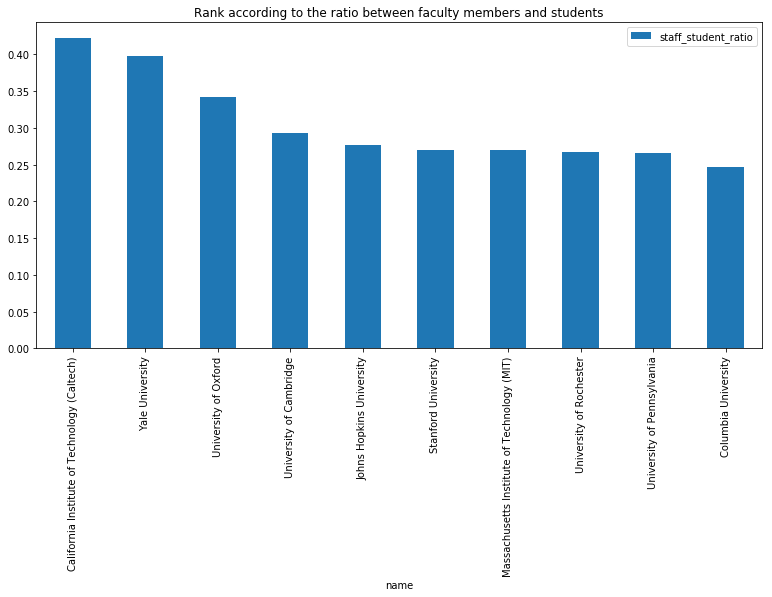

In [12]:
df.sort_values('staff_student_ratio', ascending=False)[['name', 'staff_student_ratio']].head(10).plot(title='Rank according to the ratio between faculty members and students',
                                                                                                      figsize=(13,6),kind='bar', x = 'name')

We note that most of the universities with a high ratio are also highly ranked.

## Rank according to the ratio of international students

In [13]:
df['international_student_ratio'] = df['international_student'] / df['total_student']
df.sort_values(['international_student_ratio'], ascending=[False])[['name', 'rank', 'international_student_ratio']]

,name,rank,international_student_ratio
34,London School of Economics and Political Scien...,35,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,0.570047
7,Imperial College London,8,0.543567
198,Maastricht University,199,0.502533
47,Carnegie Mellon University,47,0.478062
6,UCL (University College London),7,0.477928
91,University of St Andrews,92,0.457955
41,The University of Melbourne,41,0.427434
126,Queen Mary University of London,127,0.421816
25,The University of Hong Kong,26,0.407144


For clarity, we only show the universities with the 10 highest ratio.

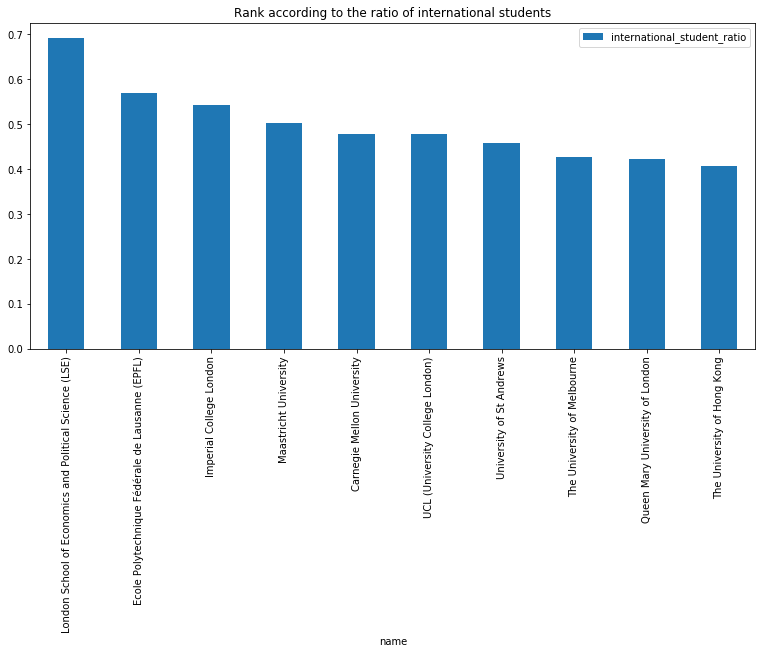

In [14]:
df.sort_values('international_student_ratio', ascending=False)[['name', 'international_student_ratio']].head(10).plot(title='Rank according to the ratio of international students',figsize=(13,6), kind='bar', x = 'name')

We can note that again, a lot of higly ranked universities also have a high ratio, but in this case, it's not as much apparent as in the previous ratio.

## Rank according to the ratio between faculty members and students, grouped by country

In [15]:
df_staff_country = df.groupby('country').mean().sort_values('staff_student_ratio', ascending=False)[['staff_student_ratio']]
df_staff_country

,staff_student_ratio
country,
Russia,0.221910
Denmark,0.186580
Saudi Arabia,0.175828
Singapore,0.162279
Japan,0.155840
Malaysia,0.153893
United States,0.151151
South Korea,0.149356
France,0.144006


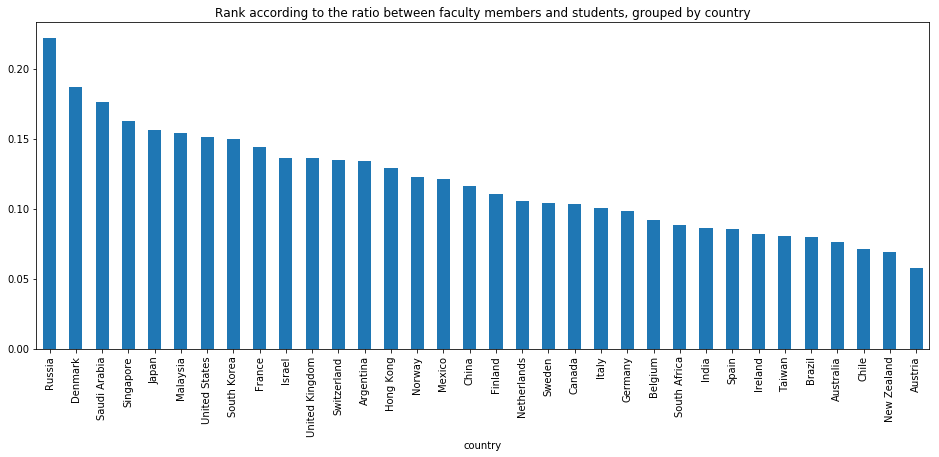

In [16]:
df_staff_country['staff_student_ratio'].plot(title='Rank according to the ratio between faculty members and students, grouped by country', figsize=(16,6),kind='bar')

Here we can note some surprising results. A lot of countries that have high ratios do not seem to have a lot of universities that are highly ranked. In fact we believe that for these countries, only a few or even a single university is in the ranking. Given that the university would be the best university in that country, it is understandable that their ratio is high.

## Rank according to the ratio between faculty members and students, grouped by region

In [17]:
df_staff_region = df.groupby('region').mean().sort_values('staff_student_ratio', ascending=False)[['staff_student_ratio']]
df_staff_region

,staff_student_ratio
region,
North America,0.144831
Asia,0.134673
Europe,0.120003
Latin America,0.096779
Africa,0.088450
Oceania,0.075003


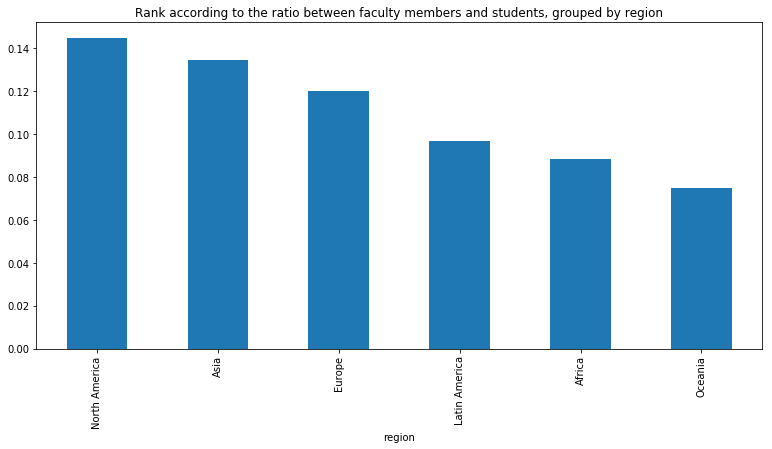

In [18]:
df_staff_region['staff_student_ratio'].plot(title = 'Rank according to the ratio between faculty members and students, grouped by region',figsize=(13,6),kind='bar')

Here we note that the highest ratios seem to be in regions that have the most of highly ranked universities.

## Rank according to the ratio of international students, grouped by country

In [19]:
df_int_country = df.groupby('country').mean().sort_values('international_student_ratio', ascending=False)[['international_student_ratio']]
df_int_country

,international_student_ratio
country,
United Kingdom,0.351308
Australia,0.346878
Switzerland,0.313816
Hong Kong,0.312148
Austria,0.306095
Singapore,0.277091
Canada,0.252604
New Zealand,0.248971
Netherlands,0.245456


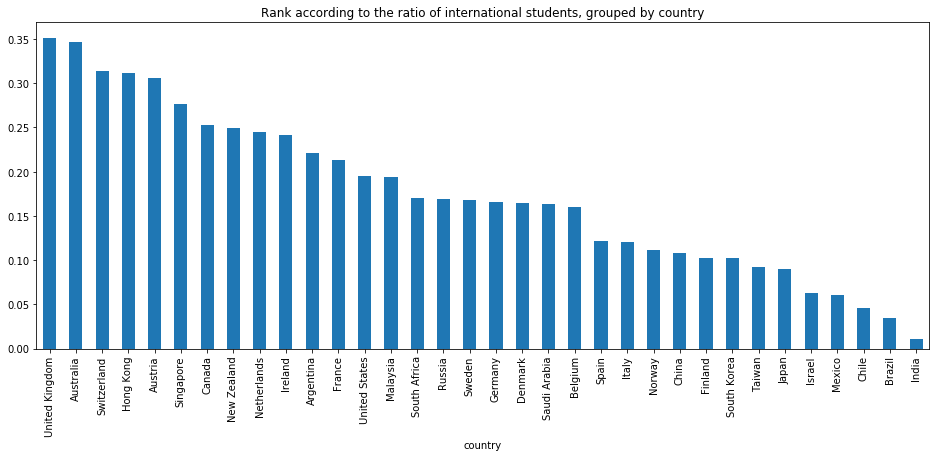

In [20]:
df_int_country['international_student_ratio'].plot(title='Rank according to the ratio of international students, grouped by country', figsize=(16,6),kind='bar')

We note that the countries that seem to have the highest ratios of international students also seem to be the most attractive in terms of their location and/or wealth.

## Rank according to the ratio of international students, grouped by region

In [21]:
df_int_region = df.groupby('region').mean().sort_values('international_student_ratio', ascending=False)[['international_student_ratio']]
df_int_region

,international_student_ratio
region,
Oceania,0.329077
Europe,0.245932
North America,0.202437
Africa,0.169703
Asia,0.132394
Latin America,0.071751


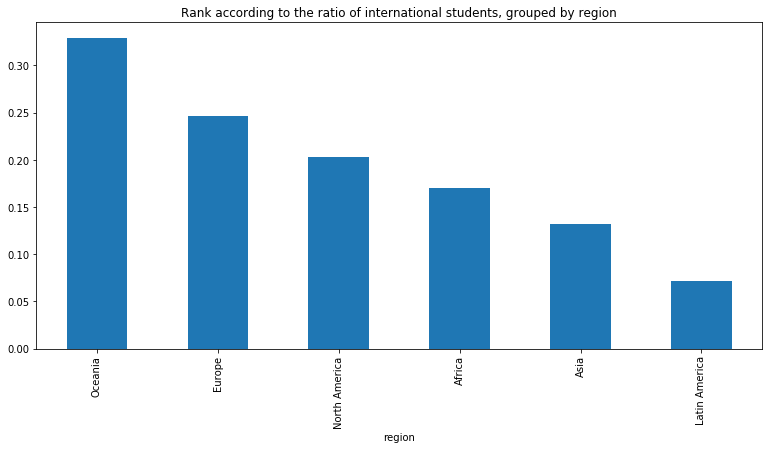

In [22]:
df_int_region['international_student_ratio'].plot(title='Rank according to the ratio of international students, grouped by region', figsize=(13,6),kind='bar')

The results by region seem to confirm the results by country. Again, attractive locations and rich countries seem to attract the most international students. Latin America and Asia however are an exception.

For the next part, where we look at the rankings of universities according to Times Higher Education, we need to define a mapping of countries and regions, since the second rankings do not contain region data and we would like to have it in our tables.

In [23]:
country_region = dict(df[['country', 'region']].groupby(['country', 'region']).groups.keys())

# 2. With Times Higher Education

Similarly to the previous part, we notice that all the relevant data can be obtained from a simple text file in JSON format. Moreover we see that the ratios we are interested in are already present in this file and need not be calculated. 

In [24]:
r2 = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
raw_data2 = json.loads(r2.text)['data'][:200]

When loading the university data from the webpage, we have to adapt it so that it matches the format from the other ranking. One problem we have is that in Times Higher Education, Russia is referred to as the Russian Federation, so we change it back to Russia. Moreover in the dictionary we created for the countries and regions, we do not have a region value for Luxemburg since it doesn't appear in the first ranking. So we manually put the region to Europe.

In [25]:
unis2 = []
for uni in raw_data2:
    name = uni['name']
    rank = uni['rank'].replace('=', '')
    country = uni['location']
    if country == 'Russian Federation':
        country = 'Russia'
    int_students = uni['stats_pc_intl_students'].replace('%', '')
    staff_student = uni['stats_student_staff_ratio']
    
    info = {'name' : name, 'rank': rank, 'country': country, 'region' : country_region.get(country, 'Europe'),
            'international_student_ratio' : int(int_students) / 100.0, 'staff_student_ratio': 1 / float(staff_student)}
    unis2.append(info)


As before, we put our data in a new JSON file to avoid reloading the file each time we run the notebook and generating new requests.

In [26]:
# Uncomment and run this if you want to regenerate the JSON
"""with open('data2.json', 'w') as f:
    json.dump(unis2, f)"""

"with open('data2.json', 'w') as f:\n    json.dump(unis2, f)"

In [27]:
with open('data2.json', 'r') as f:
    all_unis2 = json.load(f)

df2 = pd.DataFrame(all_unis2)
df2

,country,international_student_ratio,name,rank,region,staff_student_ratio
0,United Kingdom,0.38,University of Oxford,1,Europe,0.089286
1,United Kingdom,0.35,University of Cambridge,2,Europe,0.091743
2,United States,0.27,California Institute of Technology,3,North America,0.153846
3,United States,0.22,Stanford University,3,North America,0.133333
4,United States,0.34,Massachusetts Institute of Technology,5,North America,0.114943
5,United States,0.26,Harvard University,6,North America,0.112360
6,United States,0.24,Princeton University,7,North America,0.120482
7,United Kingdom,0.55,Imperial College London,8,Europe,0.087719
8,United States,0.25,University of Chicago,9,North America,0.161290
9,Switzerland,0.38,ETH Zurich – Swiss Federal Institute of Techno...,10,Europe,0.068493


## Rank according to the ratio between faculty members and students

In [28]:
df2[['name', 'staff_student_ratio']].sort_values('staff_student_ratio', ascending=False)

,name,staff_student_ratio
105,Vanderbilt University,0.303030
109,University of Copenhagen,0.243902
153,University of Rochester,0.232558
11,Yale University,0.232558
12,Johns Hopkins University,0.232558
97,Emory University,0.227273
16,Duke University,0.222222
114,École Polytechnique,0.196078
183,Scuola Normale Superiore di Pisa,0.192308
101,University of Pittsburgh,0.169492


For clarity, we only show the universities with the 10 highest ratio.

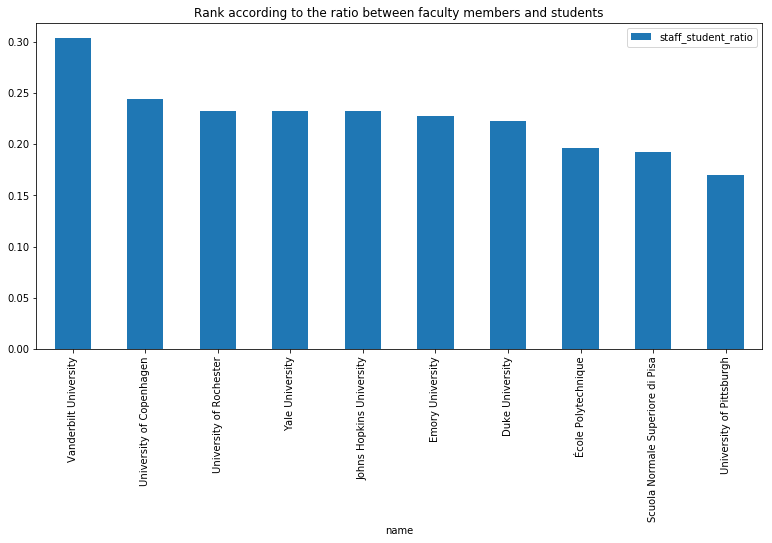

In [29]:
df2.sort_values('staff_student_ratio', ascending=False)[['name', 'staff_student_ratio']].head(10).plot(title='Rank according to the ratio between faculty members and students', figsize=(13,6),kind='bar', x = 'name')

For this ranking, we see quite a difference with the previous ranking. Here, universities with a high ratio are not necessarily the universities with the highest ranking.

## Rank according to the ratio of international students

In [30]:
df2.sort_values('international_student_ratio', ascending=False)[['name', 'international_student_ratio']]

,name,international_student_ratio
24,London School of Economics and Political Science,0.71
178,University of Luxembourg,0.57
37,École Polytechnique Fédérale de Lausanne,0.55
7,Imperial College London,0.55
102,Maastricht University,0.50
15,University College London,0.49
143,University of St Andrews,0.48
23,Carnegie Mellon University,0.45
120,Queen Mary University of London,0.45
39,University of Hong Kong,0.42


For clarity, we only show the universities with the 10 highest ratio.

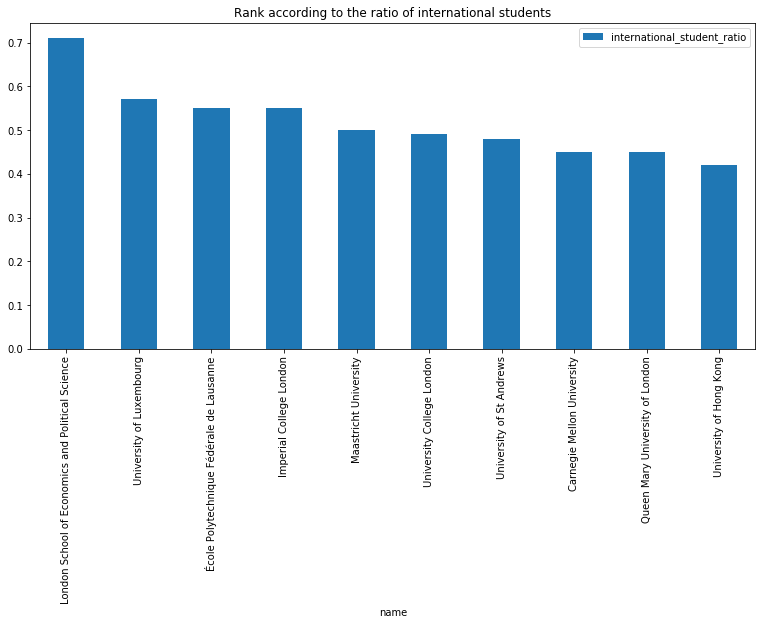

In [31]:
df2.sort_values('international_student_ratio', ascending=False)[['name', 'international_student_ratio']].head(10).plot(title='Rank according to the ratio of international students', figsize=(13,6),kind='bar', x = 'name')

The results for this ranking seem to be very similar to the other ranking with the exception of additional unversities that were not present in the other ranking.

## Rank according to the ratio between faculty members and students, grouped by country

In [32]:
df_staff_country2 = df2.groupby('country').mean().sort_values('staff_student_ratio', ascending=False)[['staff_student_ratio']]
df_staff_country2

,staff_student_ratio
country,
Denmark,0.160166
Italy,0.138889
Russia,0.136986
Japan,0.132098
United States,0.106390
France,0.099352
China,0.087420
Taiwan,0.086957
South Africa,0.085470


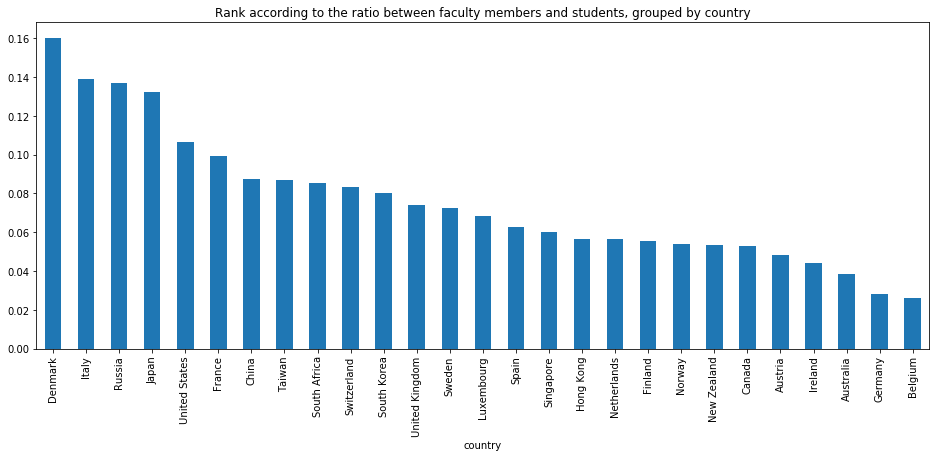

In [33]:
df_staff_country2['staff_student_ratio'].plot(title='Rank according to the ratio between faculty members and students, grouped by country', figsize=(16,6),kind='bar')

We note similar results as in the first ranking.

## Rank according to the ratio between faculty members and students, grouped by region

In [34]:
df_staff_region2 = df2.groupby('region').mean().sort_values('staff_student_ratio', ascending=False)[['staff_student_ratio']]
df_staff_region2

,staff_student_ratio
region,
North America,0.101655
Africa,0.085470
Asia,0.080345
Europe,0.065952
Oceania,0.039895


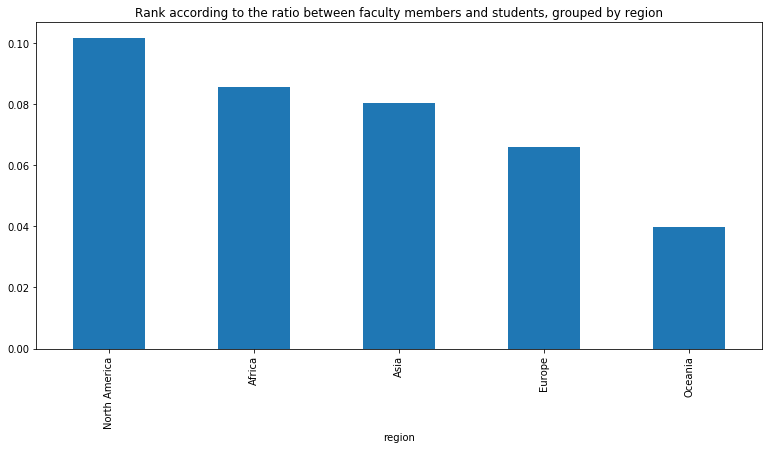

In [35]:
df_staff_region2['staff_student_ratio'].plot(title='Rank according to the ratio between faculty members and students, grouped by region', figsize=(13,6),kind='bar')

We note a few differences in this result when comparing to the first ranking. First, we see that Africa is now in second place. What happened is that all the regions seem to have a lower average ratio than in the previous ranking, but Africa's average reduced the least. Moreober, we note the dissapearance of Latin America.

## Rank according to the ratio of international students, grouped by country

In [36]:
df_int_country2 = df2.groupby('country').mean().sort_values('international_student_ratio', ascending=False)[['international_student_ratio']]
df_int_country2

,international_student_ratio
country,
Luxembourg,0.570000
United Kingdom,0.365484
Hong Kong,0.328000
Switzerland,0.314286
Australia,0.307500
Singapore,0.305000
New Zealand,0.290000
Ireland,0.270000
Austria,0.260000


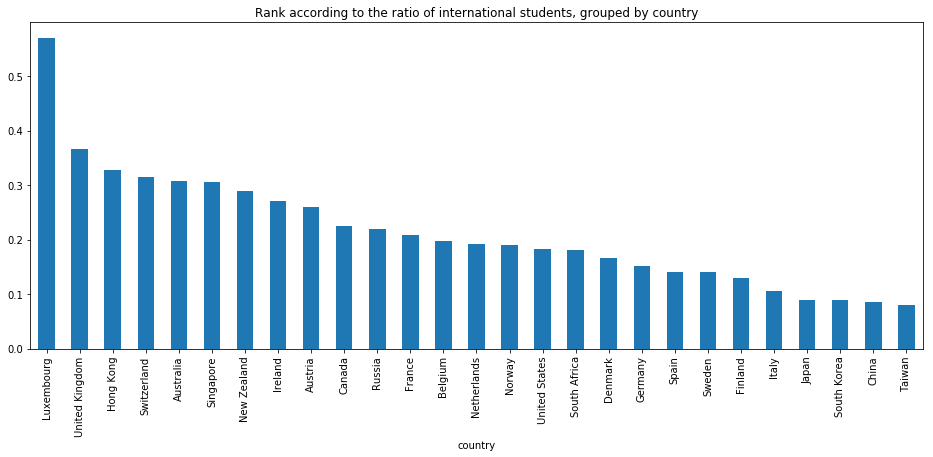

In [37]:
df_int_country2['international_student_ratio'].plot(title='Rank according to the ratio of international students, grouped by country', figsize=(16,6),kind='bar')

The results here are very similar than the previous ranking with the exception of the addition of Luxemburg, which was not present in the previous ranking.

## Rank according to the ratio of international students, grouped by region

In [38]:
df_int_region2 = df2.groupby('region').mean().sort_values('international_student_ratio', ascending=False)[['international_student_ratio']]
df_int_region2

,international_student_ratio
region,
Oceania,0.305556
Europe,0.244653
North America,0.185588
Africa,0.180000
Asia,0.165238


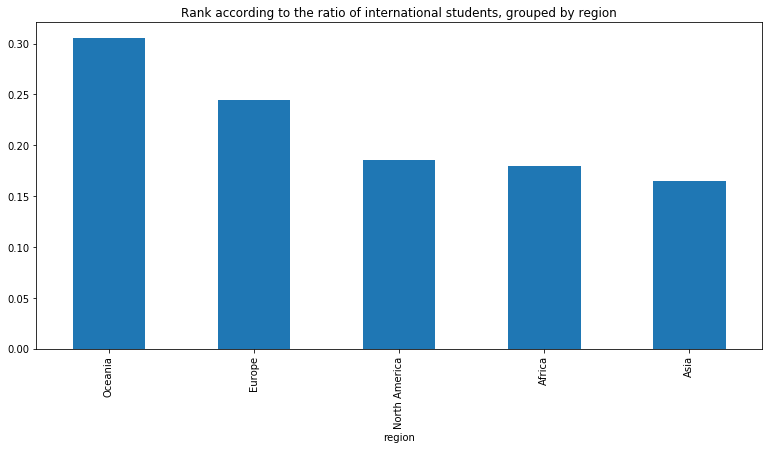

In [39]:
df_int_region2['international_student_ratio'].plot(title='Rank according to the ratio of international students, grouped by region', figsize=(13,6),kind='bar')

The results here are again very similar to the first ranking.

# 3. Merging of the two dataframes

For the third question, the goal is to merge both dataframes, and thus, as sometimes the university names are not the same in both websites, we need to map them to the same value for both to perform the merge correctly.

To solve this problem, we used Google search : we search for each university names in both dataframes, and take the first link output by Google (usually the university website), and then use this URL to perform the join.

As Google blocks any device that performs too many searches, we delayed each search by 5 seconds, and then store the mapping in a JSON file to avoid searching again each time the notebook is run.

With this technique, we have a very high rate of success, with only 3 universities for which both searches didn't output the same link. These universities were fixed manually so if you save the automatically generated JSON again below, you will not have the same mapping as we do in the file that is present in the repository.

In [40]:
mapping = {}

with open('mapping.json', 'r') as f:
    mapping = json.load(f)

In [41]:
def get_url(name):
    r = requests.get('https://encrypted.google.com/search?q=' + name.replace(' ', '+')) # request the Google results page
    soup = BeautifulSoup(r.text, 'html.parser')
    google_url = soup.select('.g a')[0]['href'] # we get the first Google result
    url = google_url[google_url.find("://")+3:google_url.find("&")] # we get the URL of the first result
    
    if url.endswith("/"):
        url = url[0:-1]
    
    time.sleep(5) # the wait needed to avoid getting blocked by Google
    return url

def get_identifier(name):
    if not(name in mapping): #if the name is already in the mapping, no need to run the search again
        mapping[name] = get_url(name)
        
    return mapping[name]


Now that we have the mapping, we can apply it to both datasets and then merge them on the 'url' column.

In [42]:
df['url'] = df['name'].apply(get_identifier)

df2['url'] = df2['name'].apply(get_identifier)

raw_merge = df.merge(df2[['url', 'rank', 'international_student_ratio', 'staff_student_ratio']], how='inner', on='url')
raw_merge.columns = ['Country', 
                     'International faculty', 
                     'International students', 
                     'Name', 
                     'Rank topuniversities', 
                     'Region', 
                     'Total faculty', 
                     'Total students', 
                     'Faculty / students ratio topuniversities', 
                     'International students ratio topuniversities', 
                     'url', 
                     'Rank timeshighereducation', 
                     'International students ratio timeshighereducation', 
                     'Faculty / students ratio timeshighereducation']
raw_merge

,Country,International faculty,International students,Name,Rank topuniversities,Region,Total faculty,Total students,Faculty / students ratio topuniversities,International students ratio topuniversities,url,Rank timeshighereducation,International students ratio timeshighereducation,Faculty / students ratio timeshighereducation
0,United States,1679.0,3717.0,Massachusetts Institute of Technology (MIT),1,North America,2982.0,11067.0,0.269450,0.335863,web.mit.edu,5,0.34,0.114943
1,United States,2042.0,3611.0,Stanford University,2,North America,4285.0,15878.0,0.269870,0.227422,www.stanford.edu,3,0.22,0.133333
2,United States,1311.0,5266.0,Harvard University,3,North America,4350.0,22429.0,0.193945,0.234785,www.harvard.edu,6,0.26,0.112360
3,United States,350.0,647.0,California Institute of Technology (Caltech),4,North America,953.0,2255.0,0.422616,0.286918,www.caltech.edu,3,0.27,0.153846
4,United Kingdom,2278.0,6699.0,University of Cambridge,5,Europe,5490.0,18770.0,0.292488,0.356899,www.cam.ac.uk,2,0.35,0.091743
5,United Kingdom,2964.0,7353.0,University of Oxford,6,Europe,6750.0,19720.0,0.342292,0.372870,www.ox.ac.uk,1,0.38,0.089286
6,United Kingdom,2554.0,14854.0,UCL (University College London),7,Europe,6345.0,31080.0,0.204151,0.477928,www.ucl.ac.uk,16,0.49,0.095238
7,United Kingdom,2071.0,8746.0,Imperial College London,8,Europe,3930.0,16090.0,0.244251,0.543567,www.imperial.ac.uk,8,0.55,0.087719
8,United States,635.0,3379.0,University of Chicago,9,North America,2449.0,13557.0,0.180645,0.249244,www.uchicago.edu,9,0.25,0.161290
9,Switzerland,1886.0,7563.0,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,2477.0,19815.0,0.125006,0.381681,www.ethz.ch/en.html,10,0.38,0.068493


In [43]:
# Uncomment and run this if you want to save the JSON
"""with open('mapping.json', 'w') as f:
    json.dump(mapping, f)"""

"with open('mapping.json', 'w') as f:\n    json.dump(mapping, f)"

# 4. Find useful insights in the data

We begin by cleaning and adapting our dataset to better see meaningful correlations. For example, we put the ranking of each unversity in the reverse order, since we want to have a higher value for higher ranked universities to get meaningful correlations. Moreover we drop some rows where we miss the data we need. We also add another ratio that we thought to be usefull for the last part of the homework, the international faculy ratio for each unversity.

In [44]:
raw_merge_cleaned = raw_merge.copy()
raw_merge_cleaned['rank_time'] = 200 - raw_merge_cleaned['Rank timeshighereducation'].astype(int)
raw_merge_cleaned['rank_top'] = 200 - raw_merge_cleaned['Rank topuniversities'].astype(int)
raw_merge_cleaned[pd.notnull(raw_merge['International students ratio topuniversities'])]
raw_merge_cleaned['International faculty ratio'] = raw_merge_cleaned['International faculty'] / raw_merge_cleaned['Total faculty']

In [45]:
raw_merge_cleaned.corr()

,International faculty,International students,Rank topuniversities,Total faculty,Total students,Faculty / students ratio topuniversities,International students ratio topuniversities,International students ratio timeshighereducation,Faculty / students ratio timeshighereducation,rank_time,rank_top,International faculty ratio
International faculty,1.000000,0.579780,-0.516205,0.645592,0.286353,0.316277,0.381998,0.327211,0.013953,0.365093,0.516205,0.600152
International students,0.579780,1.000000,-0.258194,0.414110,0.627124,-0.245137,0.528667,0.417507,-0.338509,0.254831,0.258194,0.323016
Rank topuniversities,-0.516205,-0.258194,1.000000,-0.366388,-0.020634,-0.400063,-0.317166,-0.308134,-0.213109,-0.696734,-1.000000,-0.359499
Total faculty,0.645592,0.414110,-0.366388,1.000000,0.588380,0.337531,-0.083055,-0.127747,0.168920,0.364960,0.366388,-0.095990
Total students,0.286353,0.627124,-0.020634,0.588380,1.000000,-0.430598,-0.205709,-0.277173,-0.369667,0.147799,0.020634,-0.191878
Faculty / students ratio topuniversities,0.316277,-0.245137,-0.400063,0.337531,-0.430598,1.000000,0.110572,0.133461,0.696981,0.305359,0.400063,0.073430
International students ratio topuniversities,0.381998,0.528667,-0.317166,-0.083055,-0.205709,0.110572,1.000000,0.954589,-0.074607,0.223201,0.317166,0.657059
International students ratio timeshighereducation,0.327211,0.417507,-0.308134,-0.127747,-0.277173,0.133461,0.954589,1.000000,-0.033478,0.201501,0.308134,0.640265
Faculty / students ratio timeshighereducation,0.013953,-0.338509,-0.213109,0.168920,-0.369667,0.696981,-0.074607,-0.033478,1.000000,0.120484,0.213109,-0.168201
rank_time,0.365093,0.254831,-0.696734,0.364960,0.147799,0.305359,0.223201,0.201501,0.120484,1.000000,0.696734,0.131918


We notice that there is an obvious and natural correlation between the columns corresponding to the numbers of students and faculty members. Of course, it's normal than when there are more students, there are more international students as well and more faculty members. These correlations however are not interesting.

Another uninsteresting observation are the correlations between the ratios in the two rankings.

The more interesting observations are given by the ratios than the numbers.

In [46]:
raw_merge_cleaned[['Faculty / students ratio topuniversities',
                   'International students ratio topuniversities',
                   'International students ratio timeshighereducation',
                   'Faculty / students ratio timeshighereducation',
                   'International faculty ratio',
                   'rank_time',
                   'rank_top']].corr()

,Faculty / students ratio topuniversities,International students ratio topuniversities,International students ratio timeshighereducation,Faculty / students ratio timeshighereducation,International faculty ratio,rank_time,rank_top
Faculty / students ratio topuniversities,1.000000,0.110572,0.133461,0.696981,0.073430,0.305359,0.400063
International students ratio topuniversities,0.110572,1.000000,0.954589,-0.074607,0.657059,0.223201,0.317166
International students ratio timeshighereducation,0.133461,0.954589,1.000000,-0.033478,0.640265,0.201501,0.308134
Faculty / students ratio timeshighereducation,0.696981,-0.074607,-0.033478,1.000000,-0.168201,0.120484,0.213109
International faculty ratio,0.073430,0.657059,0.640265,-0.168201,1.000000,0.131918,0.359499
rank_time,0.305359,0.223201,0.201501,0.120484,0.131918,1.000000,0.696734
rank_top,0.400063,0.317166,0.308134,0.213109,0.359499,0.696734,1.000000


When looking at only the correlations involving the ratios and ranks, we can note a few interesting things. First note the additional ratio that is the ratio of international faculty members (this information comes from the Top Universities ranking only).

First, we can note that the faculty/students ratio from Top Universities has a relatively high correlation with both ranks. There are two possible explanations in our opinion. First we can think that higher ranked universities may have more funds to hire more faculty staff. Secondly, we can also assume that universities with a higher rank may want to keep their high position or improve it by hiring more faculty members.

Another relatively important correlation we see is the correlation between international student ratio and both ranks. This can surely be explained by the attractiveness of high ranked universities to international students.

The highest correlation we observe is the one between international faculty ratio and the international students ratio. Universities that attract international students will also attract international faculty members for probably the same reason.

In [47]:
raw_merge_cleaned[['Total students',
                   'Total faculty',
                   'International faculty',
                   'International students',
                   'rank_time',
                   'rank_top']].corr()

,Total students,Total faculty,International faculty,International students,rank_time,rank_top
Total students,1.000000,0.588380,0.286353,0.627124,0.147799,0.020634
Total faculty,0.588380,1.000000,0.645592,0.414110,0.364960,0.366388
International faculty,0.286353,0.645592,1.000000,0.579780,0.365093,0.516205
International students,0.627124,0.414110,0.579780,1.000000,0.254831,0.258194
rank_time,0.147799,0.364960,0.365093,0.254831,1.000000,0.696734
rank_top,0.020634,0.366388,0.516205,0.258194,0.696734,1.000000


We can still take a quick look at the total numbers and their correlations. In fact we can see that there is almost no correlation between the total number of students and the rank. Moreover, we see also see that the higher the rank, the more faculty members there are in the university. This confirms our previous intuition when we looked at the ratios.

# 5. Find the best university

For the last question, we have the following approach. We will create new score of the universities based on the different ratio columns for which we have the correlations. Then we will calculate the weighted average of each of these scores for each university which will define the new ranking. The top scored university of this ranking will our best unversity.

The weights we use will be based on the correlations we found earlier and the explanations that we apply to them. We will apply the following weights for each collumns:
* Faculty/student ratio: 0.1 for each ranking. We consider this to be the most important factor for the rank for reasons explained above.
* International student ratios: 0.025 for each ranking. We choose this weight because we consider the ratio to be the mostly the consequence of the ranking: high ranked universities attrach more international students because of their rank.
* International faculty ratio : 0.15 (we source this statistic from only one of the rankings). This is an important factor for us because we believe that a large number of international faculty members may mean that the university is already good and attracts professors from around the world.
* Original ranks (normalized between 0 to 1, 1 being the best): 0.3 for each. Since the original ranks are made from other interesting factors that we have not explored here, it's important to take them into account at a high weight.

In [48]:
raw_merge_cleaned['score'] = (0.1 * raw_merge_cleaned['Faculty / students ratio topuniversities'] +
                              0.1 * raw_merge_cleaned['Faculty / students ratio timeshighereducation'] +
                              0.025 * raw_merge_cleaned['International students ratio topuniversities'] +
                              0.025 * raw_merge_cleaned['International students ratio timeshighereducation'] +
                              0.15 * raw_merge_cleaned['International faculty ratio'] + 
                              0.3 * (raw_merge_cleaned['rank_time'] / 200.0) +
                              0.3 * (raw_merge_cleaned['rank_top'] / 200.0))
raw_merge_cleaned[['Name', 'score']].sort_values(by='score', ascending=False).reset_index(drop=True)

,Name,score
0,Massachusetts Institute of Technology (MIT),0.730793
1,ETH Zurich - Swiss Federal Institute of Techno...,0.722603
2,University of Oxford,0.717346
3,California Institute of Technology (Caltech),0.716158
4,Imperial College London,0.715582
5,Stanford University,0.715488
6,University of Cambridge,0.707836
7,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.693362
8,Yale University,0.683177
9,UCL (University College London),0.680015


According to our new ranking, the best university is the Massachusetts Institute of Technology.